In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [98]:
class VAE(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, sos_token, sequence_length, vocab_size, num_layers=1):
        super(VAE, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.sos_token = sos_token
        self.sequence_length = sequence_length

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fclogvar = nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

        self.decoder= nn.GRU(self.embedding_dim, latent_dim, num_layers, batch_first=True)
        self.decoderrr = nn.GRU(latent_dim, latent_dim, num_layers, batch_first=True)
        self.decoder_cell = nn.GRUCell(self.embedding_dim, latent_dim)
        self.fc = nn.Linear(latent_dim, vocab_size)
        self.fc_one = nn.Linear(latent_dim, 1)
        self.softmax = nn.Softmax(dim = 2)
        self.relu = nn.ReLU()
        self.fcout = nn.Linear(self.embedding_dim, self.embedding_dim)

    def reparametrization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        embedded_input = self.embedding(x)
        #embedded_input = self.layer_norm(embedded_input)
        output, hidden = self.encoder(embedded_input)
        mu = self.fcmu(hidden)
        logvar = self.fclogvar(hidden)

        z = self.reparametrization(mu, logvar)
        #z = self.hidden_to_latent(hidden)
        sos_token = self.sos_token.repeat(x.size(0),1)
        #sos_token = self.sos_token.repeat(x.size(0),x.size(1))
        sos_token = self.embedding(sos_token)
        #sos_token = self.layer_norm(sos_token)
        #decoder_inputs = sos_token
        decoder_inputs = torch.cat((sos_token, embedded_input), dim = 1)
        #decoder_inputs = self.layer_norm(decoder_inputs)
        #output, _ = self.decoder(embedded_input, z)

        output = []
        for t in range(decoder_inputs.shape[1]):
            outputs, _ = self.decoder(decoder_inputs[:,t,:].unsqueeze(1), z)
            output.append(outputs)
        
        reconstructed_sequence = torch.cat(output, dim=1)
        reconstructed_sequence = self.fc(reconstructed_sequence)

        return mu, logvar, reconstructed_sequence[:,1:,:], embedded_input
    
    def sample(self, x, z):
        with torch.no_grad():
            embedded_input = self.embedding(x)
            #embedded_input = self.layer_norm(embedded_input)
            sos_token = self.sos_token.repeat(x.size(0),1)
            #sos_token = self.sos_token.repeat(x.size(0),x.size(1))
            sos_token = self.embedding(sos_token)
            #sos_token = self.layer_norm(sos_token)
            #decoder_inputs = sos_token
            decoder_inputs = torch.cat((sos_token, embedded_input), dim = 1)
            #output, _ = self.decoder(embedded_input, z)

            output = []
            for t in range(decoder_inputs.shape[1]):
                outputs, _ = self.decoder(decoder_inputs[:,t,:].unsqueeze(1), z)
                output.append(outputs)

            reconstructed_sequence = torch.cat(output, dim = 1)
            reconstructed_sequence = self.fc(reconstructed_sequence)

        return reconstructed_sequence[:,1:,:]

In [137]:
class ReconVAE(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, sos_token, sequence_length, vocab_size, num_layers=1):
        super(ReconVAE, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.sos_token = sos_token
        self.sequence_length = sequence_length

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fclogvar = nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)
        self.fc_latent_latent = nn.Linear(latent_dim, latent_dim)

        self.decoder= nn.GRU(latent_dim, 64, num_layers, batch_first=True)
        self.decoderrr = nn.GRU(latent_dim, latent_dim, num_layers, batch_first=True)
        self.decoder_cell = nn.GRUCell(self.embedding_dim, latent_dim)
        self.fc = nn.Linear(64, vocab_size)
        self.fc_one = nn.Linear(latent_dim, 1)
        self.softmax = nn.Softmax(dim = 2)
        self.relu = nn.ReLU()
        self.fcout = nn.Linear(self.embedding_dim, self.embedding_dim)

    def reparametrization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        embedded_input = self.embedding(x)
        #embedded_input = self.layer_norm(embedded_input)
        output, hidden = self.encoder(embedded_input)
        mu = self.fcmu(hidden[-1])
        logvar = self.fclogvar(hidden[-1])

        z = self.reparametrization(mu, logvar)

        z = self.fc_latent_latent(z)
        z = self.relu(z)
        z = z.repeat(x.size(1),1).reshape(x.size(0), x.size(1), self.latent_dim)

        reconstructed_sequence, _ = self.decoder(z)
        reconstructed_sequence = self.fc(reconstructed_sequence)

        return mu, logvar, reconstructed_sequence, embedded_input
    
    def sample(self, z, sequence_length):
        with torch.no_grad(): 
            z = self.fc_latent_latent(z)
            z = self.relu(z)
            z = z.repeat(sequence_length,1).reshape(z.size(0), sequence_length, self.latent_dim)

            reconstructed_sequence, _ = self.decoder(z)
            reconstructed_sequence = self.fc(reconstructed_sequence)

        return reconstructed_sequence

In [114]:
a = torch.randn(size=(64,136))
a = a.repeat((15,1))
a = a.reshape(64,15,136)
a.shape

torch.Size([64, 15, 136])

In [30]:
class VAeE(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, sequence_length, num_layers=1):
        super(VAE, self).__init__()
        self.embedding_dim = embedding_matrix.shape[1]

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.encoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fcmu = nn.Linear(hidden_dim, latent_dim)
        self.fclogvar = nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

        self.decoder= nn.GRU(self.embedding_dim, latent_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(latent_dim, self.embedding_dim)

    def reparametrization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        embedded_input = self.embedding(x)
        _, hidden = self.encoder(embedded_input)
        mu = self.fcmu(hidden)
        logvar = self.fclogvar(hidden)

        #z = self.reparametrization(mu, logvar)
        z = self.hidden_to_latent(hidden)
        decoder_inputs = torch.zeros(x.size(0), x.size(1), embedded_input.size(2))
        output, _ = self.decoder(decoder_inputs, z)
        '''decoder_inputs = embedded_input
        output = []
        for t in range(x.size(1)):
            output_sequence, _ = self.decoder(decoder_inputs[:,t:t+1], z)
            #decoder_inputs = output_sequence
            output.append(output_sequence)

        output = torch.cat(output, dim = 1)'''
        reconstructed_sequence = self.fc(output)

        return mu, logvar, reconstructed_sequence, embedded_input
        

# usa questo

In [3]:
input = torch.FloatTensor(size=(32,15,300))

In [7]:
input[:,1:].shape

torch.Size([32, 14, 300])

In [6]:
input = input.view(-1,input.size(2))

In [4]:
input.shape

torch.Size([32, 15, 300])

In [229]:
uno = torch.FloatTensor(size=(32,136))
due = torch.FloatTensor(size=(32,136))
tre = torch.stack((uno,due),dim=1)

In [230]:
tre.shape

torch.Size([32, 2, 136])

# questi sotto non usarli!

# Train function

In [5]:
def vae_loss(recon_x, x, mu, log_var, l_s = 1, loss_fn = nn.MSELoss(), cos_loss = nn.CosineSimilarity(dim=2), CE = nn.CrossEntropyLoss()):
    #BCE = loss_fn(recon_x, x)
    #BCE = 1 - cos_loss(recon_x,x).mean()
    BCE = CE(recon_x.reshape((recon_x.size(0)*recon_x.size(1),recon_x.size(2))),x.view(-1))
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + l_s*KLD

In [56]:
def training_VAE(vae, train_loader, val_loader, num_epochs, vocab_size, lr = 1e-3):
    params = list(vae.parameters())

    optimizer = torch.optim.Adam(params, lr = lr)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0

        for data,_,_ in train_loader:
            data = data.to(device)
            
            optimizer.zero_grad()

            mu, log_var, reconstructed_data, embedded_input = vae(data)

            loss = vae_loss(reconstructed_data, data, mu, log_var)
            loss.backward()
            train_loss += loss.item()

            optimizer.step()

        average_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch+1} Average loss: {average_loss:.4f}')
        train_losses.append(average_loss)

        with torch.no_grad():
            for data,_,_ in val_loader:
                data = data.to(device)
                

                mu, log_var, reconstructed_data, embedded_input = vae(data)
                
                loss = vae_loss(reconstructed_data, data, mu, log_var)
                val_loss += loss.item()

        
        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)

    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return train_losses

In [7]:
def BoW(tensor):
    bow = torch.zeros(size = (tensor.shape[0],tensor.shape[1]))
    #BoW = [(data1[i] == num).sum().item()/data1.shape[1]  for i in range(data1.shape[0]) for num in data1[i] if BoW[i][torch.where(data1[i] == num)[0][0].item()]==0]

    for i in range(tensor.shape[0]):
        for num in tensor[i]:
            index = torch.where(tensor[i] == num)[0][0].item()
            bow[i][index] = (tensor[i] == num).sum().item()/tensor.shape[1]

    return torch.FloatTensor(bow)

In [8]:
def divide_text(text, sequence_length):
    words = text.split()
    #words = text
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length))]  # range (0,len(words),8)
    #grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),2)]
    #grouped_words = [words[i] for i in range(0,len(words),19)]
    #grouped_words_2d = [sentence.split() for sentence in grouped_words]
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]
    return output_text

In [9]:
def custom_dataset(file1 : str,file2 : str, sequence_length, embedding_dim, batch_size, training_fraction):

    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()

    text1 = '<sos> ' + text1
    text = text1 + ' ' + text2
    divided_text = divide_text(text, sequence_length)

    #word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = int(sequence_length/2), min_count=1, workers=4)
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = 5, min_count=1, workers=4, epochs=50)
    #word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=20)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    # Convert to PyTorch tensor
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)



    text1_divided = divide_text(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])


    text2_divided = divide_text(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]):]

    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]):]


    label0_train = torch.zeros(data1_train.shape[0])
    label0_val = torch.zeros(data1_val.shape[0])

    label1_train = torch.ones(data2_train.shape[0])
    label1_val = torch.ones(data2_val.shape[0])


    labels_train = torch.cat((label0_train, label1_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val), dim = 0)

    data_train = torch.cat((data1_train, data2_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)
    bow_train = BoW(data_train)

    dataset_train = TensorDataset(data_train, bow_train, labels_train)

    # Create a DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
    #dataloader_train = DataLoader(dataset_train, batch_size = batch_size)


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)
    bow_val = BoW(data_val)

    dataset_val = TensorDataset(data_val, bow_val, labels_val)

    # Create a DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    #dataloader_val = DataLoader(dataset_val, batch_size = batch_size)

    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, word2idx, idx2word, vocab_size

In [10]:
sequence_length = 15
embedding_dim = 300
hidden_dim = 256
latent_dim = 136
batch_size = 64

In [117]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, word2idx, idx2word, vocab_size = custom_dataset('divina_commedia.txt', 
                                                                                    'uno_nessuno_e_i_malavoglia.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = batch_size, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))

len train loader:  191


In [118]:
vocab_size

12762

In [57]:
sos_token = torch.full((1,),word2idx['<sos>'])

In [58]:
sos_token = sos_token.type(torch.LongTensor)

In [59]:
sos_token.shape

torch.Size([1])

In [53]:
sos_token = sos_token.repeat(64,1)

In [138]:
#vae = VAE(embedding_matrix, hidden_dim, latent_dim, sos_token, sequence_length, vocab_size, num_layers = 1)
vae = ReconVAE(embedding_matrix, hidden_dim, latent_dim, sos_token, sequence_length, vocab_size, num_layers = 1)

In [139]:
vae_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Total parameters: ', vae_params)

Total parameters:  1801879


  0%|          | 0/3 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 0.2414


 33%|███▎      | 1/3 [00:18<00:37, 18.82s/it]

====> Epoch: 2 Average loss: 0.1141


 67%|██████▋   | 2/3 [00:36<00:17, 17.95s/it]

====> Epoch: 3 Average loss: 0.1120


100%|██████████| 3/3 [00:55<00:00, 18.66s/it]


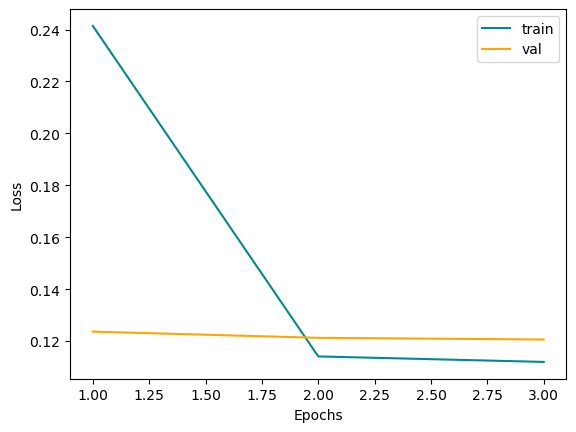

In [140]:
losses = training_VAE(vae, train_loader, val_loader, 3, vocab_size)

In [141]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    mu, log_var, reconstructed, embedded_input = vae(prova)

indices = torch.argmax(reconstructed, dim=2)

ricostruzione = []
for i in range(prova.shape[1]):
    ricostruzione.append(idx2word[indices[0][i].item()])

print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))

z = torch.randn(size=(1,latent_dim))
z1 = torch.randint(0,vocab_size,size=(1,15))
x = torch.zeros(size=(1,15)).type(torch.LongTensor)
x = sos_token.repeat(1,15)
nuovo = vae.sample(z, sequence_length)

index = nuovo.argmax(dim=-1)

generata = []
for i in range(prova.shape[1]):
    generata.append(idx2word[index[0][i].item()])

print("\nGenerated sequence: \n", ' '.join(generata))

Input sequence: 
 fiumana uscian faville vive e d ogne parte si mettien ne fiori quasi rubin che

Reconstructed sequence: 
 e e e e e e e e e e e e e e e

Generated sequence: 
 e e e e e e e e e e e e e e e


In [135]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    mu, log_var, reconstructed, embedded_input = vae(prova)

indices = torch.argmax(reconstructed, dim=2)

ricostruzione = []
for i in range(prova.shape[1]):
    ricostruzione.append(idx2word[indices[0][i].item()])

print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))

z = torch.randn(size=(1,1,latent_dim))
z1 = torch.randint(0,vocab_size,size=(1,15))
x = torch.zeros(size=(1,15)).type(torch.LongTensor)
x = sos_token.repeat(1,15)
nuovo = vae.sample(prova, z)

index = nuovo.argmax(dim=-1)

generata = []
for i in range(prova.shape[1]):
    generata.append(idx2word[index[0][i].item()])

print("\nGenerated sequence: \n", ' '.join(generata))

Input sequence: 
 di dio per cu io vidi l alto triunfo del regno verace dammi virtù a

Reconstructed sequence: 
 l e e e e e e e e e e e e e e


TypeError: repeat(): argument 'repeats' (position 1) must be tuple of ints, but found element of type Tensor at pos 0

In [79]:
nuovo.shape

torch.Size([1, 0, 20249])

In [105]:
z1

tensor([[19999, 15612,   803,  9050,  8297, 13471, 14120, 19550,  8031,  1264,
         15653,  6449, 14939,  9195,  9682]])

In [111]:
index[0]

tensor([ 337,    0,   56, 1547,    1,  103,  330,  269,    0,    4,  131,    5,
        1944,   49, 1369])

In [112]:
prova

tensor([[ 337,    0,   56, 6901,    1,  103,  330,  269,    0,    4,  131,    5,
         5569,   49, 5529]])

In [154]:
z = torch.randn(size=(1,1,latent_dim))
z1 = torch.randint(0,vocab_size,size=(1,15))
x = torch.zeros(size=(1,15)).type(torch.LongTensor)
x = sos_token.repeat(1,15)
nuovo = vae.sample(prova, z)
nuovo.shape
index = nuovo.argmax(dim=-1)

ricostruzione = []
for i in range(prova.shape[1]):
    ricostruzione.append(idx2word[index[0][i].item()])

print("\nReconstructed sequence: \n", ' '.join(ricostruzione))


Reconstructed sequence: 
 tu a la virtù prender la tua misura non a la venendo de le creature


In [35]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    mu, log_var, reconstructed, embedded_input = vae(prova)

reconstructed = reconstructed.view(reconstructed.shape[1], reconstructed.shape[2])
ricostruzione = []
for i in range(reconstructed.shape[0]):
    ricostruzione.append((word2vec.wv.most_similar(np.array(reconstructed[i]),topn=1)[0][0]))

if labels.item() == 0.0:
    stile = 'Dante'
else: 
    stile = 'Italiano'

print('Stile: ', stile)
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))

ValueError: operands could not be broadcast together with shapes (300,) (20249,) (300,) 

In [155]:
z = torch.randn(1,1, latent_dim)

with torch.no_grad():
    out = vae.decode(z)

print(out.shape)
out = out.view(out.shape[1],out.shape[2])

nuova_frase = []
for i in range(out.shape[0]):
    nuova_frase.append((word2vec.wv.most_similar(np.array(out[i]),topn=1)[0][0]))

print("\nNew sequence: \n", ' '.join(nuova_frase))

AttributeError: 'VAE' object has no attribute 'decode'

In [46]:
out.shape

torch.Size([15, 300])

In [35]:
reconstructed.shape

torch.Size([1, 15, 300])

In [16]:
mu.shape

torch.Size([1, 136])

In [19]:
z = torch.randn(1,latent_dim).to(device)

with torch.no_grad():
    out = VAE.sample(prova,z)

ricostruzione = []
for i in range(out.shape[0]):
    ricostruzione.append((word2vec.wv.most_similar(np.array(out[i]),topn=1)[0][0]))

In [20]:
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))


Reconstructed sequence: 
 laggiù all ospedale la nunziata si metteva a piangere anch essa e diceva di no
